In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType, col, when, max, min, rand, hour, minute, expr
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from functools import reduce

In [2]:
# Building session now
spark = SparkSession.builder.appName('E4_template').getOrCreate()


In [3]:
# Load data from csv
df1 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2005_to_2007.csv', header=True, inferSchema=True)
df2 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2009_to_2011.csv', header=True, inferSchema=True)
df3 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2012_to_2014.csv', header=True, inferSchema=True)
# Combine the DataFrames into a single DataFrame
data = df1.union(df2).union(df3)

In [4]:
# Set label values
print(data.count())
data = data.withColumn('Accident_Severity', when(data.Accident_Severity == 1, 0).otherwise(data.Accident_Severity))
data = data.withColumn('Accident_Severity', when(data.Accident_Severity == 2, 1).otherwise(data.Accident_Severity))
data = data.withColumn('Accident_Severity', when(data.Accident_Severity == 3, 2).otherwise(data.Accident_Severity))

1504150


In [5]:
df = data
# get class counts
df_majority = df.filter(col("Accident_Severity") == 2)
df_minority_1 = df.filter(col("Accident_Severity") == 1)
df_minority_2 = df.filter(col("Accident_Severity") == 0)
majority = df_majority.count()
minority_1 = df_minority_1.count()
minority_2 = df_minority_2.count()
print(majority)
print(minority_1)
print(minority_2)

1280205
204504
19441


In [6]:
# Downsample frequent classes
ratio_majority = float(minority_2 / majority)
ratio_minority_1 = float(minority_2 / minority_1)
print(ratio_majority, ratio_minority_1)

0.015185849141348457 0.09506415522434769


In [7]:
# Resample to get balanced data between classes
df_undersampled_minority_1 = df_minority_1.sample(False, ratio_minority_1, seed=42)
df_undersampled_majority = df_majority.sample(False, ratio_majority, seed=42)
print(df_undersampled_majority.count())
print(df_undersampled_minority_1.count())
print(df_minority_2.count())

19410
19625
19441


In [8]:
# Combine into a new dataframe
balanced_df = df_undersampled_minority_1.union(df_undersampled_majority).union(df_minority_2)

In [9]:
balanced_df.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Time: string (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-- 2

In [10]:
# choose columns for analysis
balanced_df = balanced_df.select("Accident_Severity",
                           "Day_of_week",
                           "Speed_limit",
                           "Urban_or_Rural_Area",
                           "1st_Road_Class",
                           "2nd_Road_Class",
                           "Light_Conditions",
                           "Weather_Conditions",
                           "Road_Surface_Conditions", 
                           "Police_Force",
                           "Number_of_Vehicles",
                           "Number_of_Casualties",
                           "Local_Authority_(District)",
                           "Local_Authority_(Highway)",
                           "Road_Type",
                           "Pedestrian_Crossing-Human_Control",
                           "Pedestrian_Crossing-Physical_Facilities",
                           "Special_Conditions_at_Site",
                           "Carriageway_Hazards",
                           "Did_Police_Officer_Attend_Scene_of_Accident",
                           "Year"
                           )
# rename error causing column names
balanced_df = balanced_df.withColumnRenamed("Local_Authority_(District)", "Local_Authority_District")
balanced_df = balanced_df.withColumnRenamed("Local_Authority_(Highway)", "Local_Authority_Highway")
balanced_df = balanced_df.withColumnRenamed("Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing_Human_Control")
balanced_df = balanced_df.withColumnRenamed("Pedestrian_Crossing-Physical_Facilities", "Pedestrian_Crossing_Physical_Facilities")
# drop rows with null values
balanced_df = balanced_df.dropna(how='any', thresh=None, subset=None)

In [11]:
# rename label column
balanced_df = balanced_df.withColumnRenamed("Accident_Severity", "label")
# cast ints to double
for i, column in zip(balanced_df.dtypes, balanced_df.columns):
    if i[1] == 'int' and i[0] != 'label':
        balanced_df = balanced_df.withColumn(column, col(column).cast("double"))

In [12]:
# Split dataset
train, validation, test = balanced_df.randomSplit([0.7, 0.2, 0.1], 1234)

In [13]:
# get categorical and numeric columns, set indexers
categorical_columns = [item[0] for item in balanced_df.dtypes if item[1].startswith('string')]
numeric_columns = [item[0] for item in balanced_df.dtypes if item[1].startswith('double')]
indexers = [StringIndexer(inputCol=column, outputCol='{0}_index'.format(column)) for column in categorical_columns]

In [14]:
print(categorical_columns, numeric_columns)

['Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Local_Authority_Highway', 'Road_Type', 'Pedestrian_Crossing_Human_Control', 'Pedestrian_Crossing_Physical_Facilities', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Did_Police_Officer_Attend_Scene_of_Accident'] ['Day_of_week', 'Speed_limit', 'Urban_or_Rural_Area', '1st_Road_Class', '2nd_Road_Class', 'Police_Force', 'Number_of_Vehicles', 'Number_of_Casualties', 'Local_Authority_District', 'Year']


In [15]:
# Establish features as per Exercise 4
featuresCreator = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numeric_columns, outputCol="features")

In [16]:
# Define layer structure and calssifier to be used
layers = [len(featuresCreator.getInputCols()), 10, 10, 3]
classifier = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', maxIter=100, layers=layers, blockSize=128, stepSize=0.1, seed=1234)

In [17]:
# Define pipeline
pipeline = Pipeline(stages=indexers + [featuresCreator, classifier])

In [18]:
# Train model
model = pipeline.fit(train)

In [19]:
# get predictions
train_output_df = model.transform(train)
validation_output_df = model.transform(validation)
test_output_df = model.transform(test)

In [20]:
# calculate metrics
train_predictionAndLabels = train_output_df.select("prediction", "label")
validation_predictionAndLabels = validation_output_df.select("prediction","label")
test_predictionAndLabels = test_output_df.select("prediction", "label")
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' +
    str(evaluator.evaluate(train_predictionAndLabels)))
    print('Validation ' + metric + ' = ' +
    str(evaluator.evaluate(validation_predictionAndLabels)))
    print('Test ' + metric + ' = ' +
    str(evaluator.evaluate(test_predictionAndLabels)))

Train weightedPrecision = 0.10928268711549477
Validation weightedPrecision = 0.11137620228405117
Test weightedPrecision = 0.11091643552674937
Train weightedRecall = 0.33057932045954536
Validation weightedRecall = 0.3337307332027591
Test weightedRecall = 0.33304119193689746
Train accuracy = 0.33057932045954536
Validation accuracy = 0.3337307332027591
Test accuracy = 0.33304119193689746


In [21]:
# Ex4 confusion matrix plotting function
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
#Get Class labels
class_temp = test_predictionAndLabels.select("label").groupBy("label").count().sort('label', ascending=False).toPandas()
print(class_temp)

   label  count
0      2   1900
1      1   1876
2      0   1929


In [23]:
#Calculate confusion matrix
from sklearn.metrics import confusion_matrix
y_true = test_predictionAndLabels.select("label")
y_true = y_true.toPandas()
y_pred = test_predictionAndLabels.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp['label'])
cnf_matrix


array([[1900,    0,    0],
       [1876,    0,    0],
       [1929,    0,    0]])

Confusion matrix, without normalization
[[1900    0    0]
 [1876    0    0]
 [1929    0    0]]


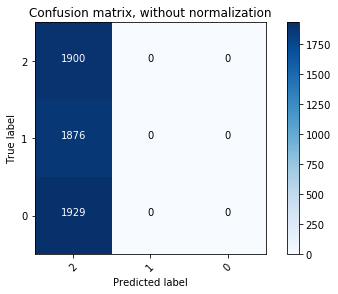

In [24]:
#Plotting Results
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp['label'].values, title='Confusion matrix, without normalization')
plt.show()